In [30]:
import MySQLdb # importação da biblioteca mysqlclient
import sqlalchemy
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType, BooleanType, StructField, DoubleType
from pyspark.ml.feature import MinMaxScaler
spark = (SparkSession.builder
        .appName("Projeto_aplicado_decision_tree")
        .getOrCreate())

In [31]:
user = 'root'
password = 'root'
host = 'localhost'
database = 'empresas_pa' #schema

string_conexao = f'mysql://{user}:{password}@{host}/{database}'

import pandas as pd  
from sqlalchemy import create_engine 
cnx = create_engine(string_conexao).connect() 

sql = """SELECT emp.id_empresa, emp.nome_empresa, emp.papel_empresa, emp.qtd_cotas, emp.setor_empresa, emp.sub_setor_empresa, cot.data_cotacao, cot.valor, ind.EV, ind.DB_PL, ind.EV_EBIT, ind.P_L, ind.P_VPA, ind.ROE FROM empresas_pa.empresas as emp 
    INNER JOIN empresas_pa.cotacao as cot ON emp.id_empresa = cot.id_empresa
    LEFT JOIN empresas_pa.indicadores as ind ON cot.id_empresa = ind.id_empresa and cot.data_cotacao = ind.data
    WHERE emp.id_empresa = 490 and cot.data_cotacao <= '2023-03-31'"""

df = pd.read_sql_query(sql, cnx) 

In [32]:
# normalização dos dados
for column in ["EV", "DB_PL", "EV_EBIT", "P_L", "P_VPA", "ROE"]:
    new_values = []
    indice = 0
    for i in df[column]:
        value = None
        if str(i) == "nan":
            for j in df[column][indice:]:
                if str(j) != "nan":
                    value = j
                    break
        else:
            value = i
        
        new_values.append(value)            
        indice += 1

    df[column] = new_values

In [33]:
df

,id_empresa,nome_empresa,papel_empresa,qtd_cotas,setor_empresa,sub_setor_empresa,data_cotacao,valor,EV,DB_PL,EV_EBIT,P_L,P_VPA,ROE
0,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2013-11-11,13.0315,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
1,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2013-11-12,12.8026,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
2,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2013-11-13,12.7762,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
3,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2013-11-14,13.0667,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
4,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2013-11-18,13.2164,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2023-03-27,13.9300,2.173270e+11,0.044581,3.97759,15.3107,2.65592,0.173468
2319,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2023-03-28,14.5900,2.173270e+11,0.044581,3.97759,15.3107,2.65592,0.173468
2320,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2023-03-29,14.8100,2.173270e+11,0.044581,3.97759,15.3107,2.65592,0.173468
2321,490,AMBEV S/A,ABEV3,15753800000,Bebidas,Cervejas e Refrigerantes,2023-03-30,14.8200,2.173270e+11,0.044581,3.97759,15.3107,2.65592,0.173468


In [34]:
df_final = df

df_final = df_final.drop(columns = ["id_empresa", "nome_empresa", "papel_empresa", "qtd_cotas", "setor_empresa", 
                                    "sub_setor_empresa"])

df_final

,data_cotacao,valor,EV,DB_PL,EV_EBIT,P_L,P_VPA,ROE
0,2013-11-11,13.0315,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
1,2013-11-12,12.8026,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
2,2013-11-13,12.7762,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
3,2013-11-14,13.0667,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
4,2013-11-18,13.2164,1.985360e+11,0.070764,5.28254,16.8224,5.21749,0.310151
...,...,...,...,...,...,...,...,...
2318,2023-03-27,13.9300,2.173270e+11,0.044581,3.97759,15.3107,2.65592,0.173468
2319,2023-03-28,14.5900,2.173270e+11,0.044581,3.97759,15.3107,2.65592,0.173468
2320,2023-03-29,14.8100,2.173270e+11,0.044581,3.97759,15.3107,2.65592,0.173468
2321,2023-03-30,14.8200,2.173270e+11,0.044581,3.97759,15.3107,2.65592,0.173468


In [35]:
dados = spark.createDataFrame(df_final)

In [36]:
#transformando os dados (linhas) em vetores
from pyspark.ml.feature import VectorAssembler  #importando a biblioteca responsável por criar o vetor a partir da coluna

all_cols = ['EV', 'DB_PL', 'EV_EBIT', 'P_L', 'P_VPA', 'ROE']

assembler = VectorAssembler(inputCols=all_cols, outputCol='features')  #define o objeto para transformação
df_dados = assembler.transform(dados) #aplica a transformação
df_dados.printSchema()

root
 |-- data_cotacao: date (nullable = true)
 |-- valor: double (nullable = true)
 |-- EV: double (nullable = true)
 |-- DB_PL: double (nullable = true)
 |-- EV_EBIT: double (nullable = true)
 |-- P_L: double (nullable = true)
 |-- P_VPA: double (nullable = true)
 |-- ROE: double (nullable = true)
 |-- features: vector (nullable = true)



In [37]:
dados_final = df_dados.select(['features','valor'])
dados_final.show(5)

+--------------------+-------+
|            features|  valor|
+--------------------+-------+
|[1.98536E11,0.070...|13.0315|
|[1.98536E11,0.070...|12.8026|
|[1.98536E11,0.070...|12.7762|
|[1.98536E11,0.070...|13.0667|
|[1.98536E11,0.070...|13.2164|
+--------------------+-------+
only showing top 5 rows



In [38]:
# Split the data into training and test sets
train_data, test_data = dados_final.randomSplit([0.7, 0.3])

In [39]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [40]:
ridge_regression = LinearRegression(featuresCol="features", labelCol="valor", elasticNetParam=0)

In [41]:
# Define the hyperparameter grid
param_grid = ParamGridBuilder() \
    .addGrid(ridge_regression.regParam, [0.001, 0.01, 0.1, 1.0]) \
    .build()

# Create the cross-validator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol= "valor", metricName="rmse")
cross_validator = CrossValidator(estimator=ridge_regression,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)

# Train the model with the best hyperparameters
cv_model = cross_validator.fit(train_data)
ridge_model = cv_model.bestModel

In [42]:
results = ridge_model.evaluate(train_data)
print('Rsquared Error :', results.r2)

Rsquared Error : 0.4531862523883269


In [43]:
coefficients = ridge_model.coefficients
intercept = ridge_model.intercept

print("Coefficients: ", coefficients)
print("Intercept: {:.3f}".format(intercept))

Coefficients:  [2.3932267251051618e-11,-31.25098793640733,-0.27147523474578017,-0.20221755718771914,2.5330722657752798,-43.008192278347465]
Intercept: 15.636


In [44]:
feature_importance = sorted(list(zip(df_dados.columns[:-1], map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

Feature Importance:
  P_L: 43.008
  valor: 31.251
  EV_EBIT: 2.533
  EV: 0.271
  DB_PL: 0.202
  data_cotacao: 0.000


In [45]:
# Make predictions on the test data
predictions = ridge_model.transform(test_data)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(predictionCol="prediction", labelCol="valor", metricName="r2").evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R2):", r2)

Root Mean Squared Error (RMSE): 1.4047477800783257
Coefficient of Determination (R2): 0.42590549043376646


In [46]:
predictions.show(5)

+--------------------+-------+------------------+
|            features|  valor|        prediction|
+--------------------+-------+------------------+
|[1.8656E11,0.0650...|11.9044|11.804859014465096|
|[1.8656E11,0.0650...|12.0718|11.804859014465096|
|[1.8656E11,0.0650...|12.2743|11.804859014465096|
|[1.8656E11,0.0650...|12.3447|11.804859014465096|
|[1.8656E11,0.0650...| 12.468|11.804859014465096|
+--------------------+-------+------------------+
only showing top 5 rows



In [47]:
resultado = pd.DataFrame({
    "valor": predictions.select(predictions.valor).toPandas()["valor"],
    "prediction": predictions.select(predictions.prediction).toPandas()["prediction"]
})

In [48]:
len(resultado['prediction'])

694

In [49]:
import matplotlib.pyplot as plt

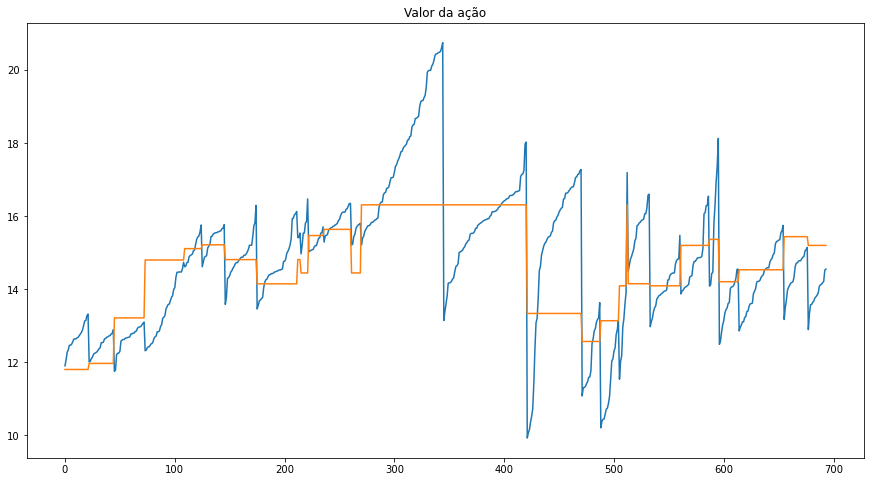

In [50]:
array_dados = range(len(resultado['prediction']))
plt.figure(figsize=(15, 8))
plt.title("Valor da ação")
plt.plot(array_dados, resultado['valor'], label="valor")
plt.plot(array_dados, resultado['prediction'], label="previsão")

            valor        EV     DB_PL   EV_EBIT       P_L     P_VPA       ROE
valor    1.000000  0.572914 -0.092721  0.357733  0.476548  0.103073 -0.196897
EV       0.572914  1.000000  0.175434  0.775230  0.689419  0.505146  0.091278
DB_PL   -0.092721  0.175434  1.000000  0.504601  0.389459  0.586317  0.359419
EV_EBIT  0.357733  0.775230  0.504601  1.000000  0.663987  0.836785  0.456848
P_L      0.476548  0.689419  0.389459  0.663987  1.000000  0.286988 -0.265959
P_VPA    0.103073  0.505146  0.586317  0.836785  0.286988  1.000000  0.836833
ROE     -0.196897  0.091278  0.359419  0.456848 -0.265959  0.836833  1.000000


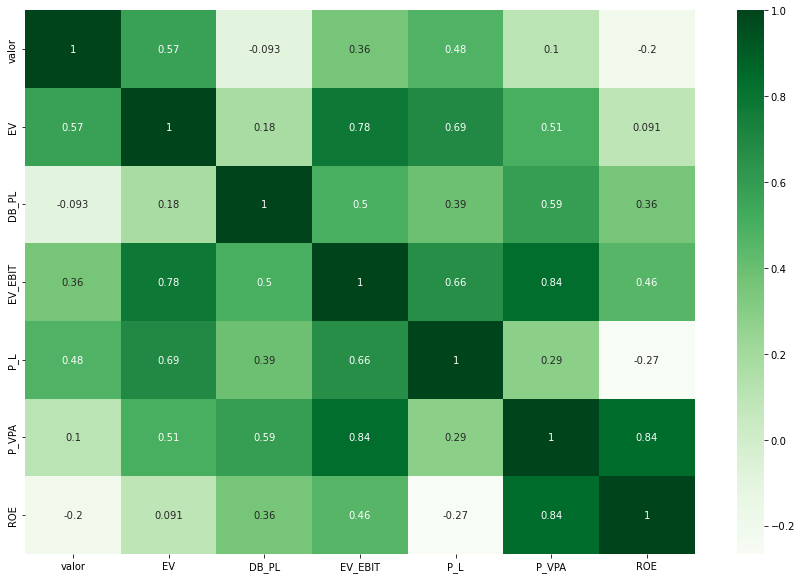

In [52]:
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.heatmap(df_final.corr(), annot=True, cmap='Greens')
print(df_final.corr())